In [ ]:
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
# import spotipy
# from spotipy.oauth2 import SpotifyClientCredentials
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
spotify = pd.read_csv("/content/drive/MyDrive/IE_5533_final_project/spotify.csv").drop_duplicates(subset=['name', 'artists'], keep='first')
X = spotify.select_dtypes(np.number)

In [ ]:
# check for missing vals.
bool(X.isnull().values.any())

False

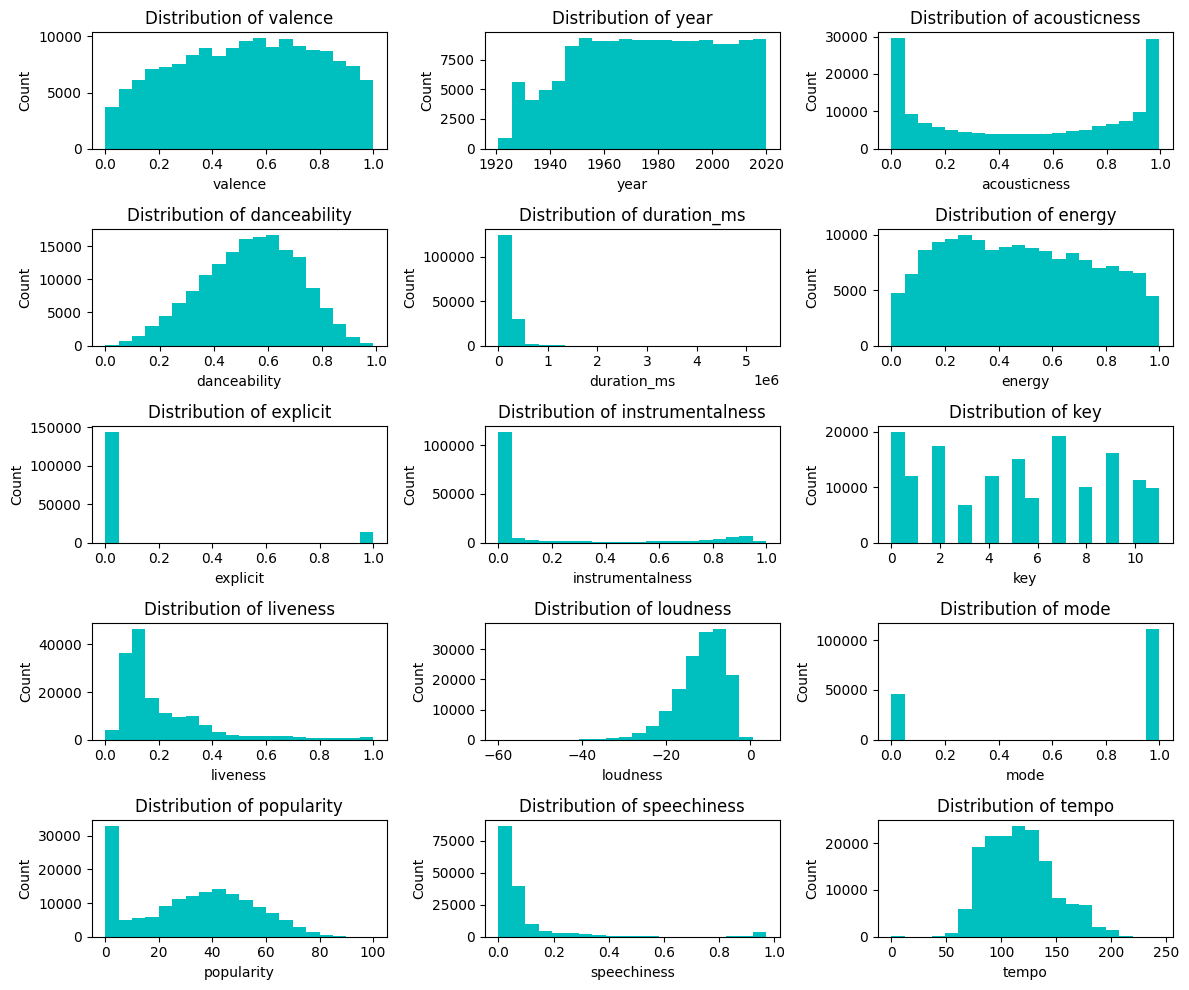

In [ ]:
features = list(X.columns)
n_features = len(features)

fig, axes = plt.subplots(5, 3, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
  axes[i].hist(X[feature], bins = 20, color="c")
  axes[i].set_title(f"Distribution of {feature}")
  axes[i].set_xlabel(feature)
  axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [ ]:
for i, feature in enumerate(features):
  print("Range of {}: {} - {}".format(feature, X[feature].min(), X[feature].max()))

Range of valence: 0.0 - 1.0
Range of year: 1921 - 2020
Range of acousticness: 0.0 - 0.996
Range of danceability: 0.0 - 0.988
Range of duration_ms: 5108 - 5403500
Range of energy: 0.0 - 1.0
Range of explicit: 0 - 1
Range of instrumentalness: 0.0 - 1.0
Range of key: 0 - 11
Range of liveness: 0.0 - 1.0
Range of loudness: -60.0 - 3.855
Range of mode: 0 - 1
Range of popularity: 0 - 100
Range of speechiness: 0.0 - 0.97
Range of tempo: 0.0 - 243.507


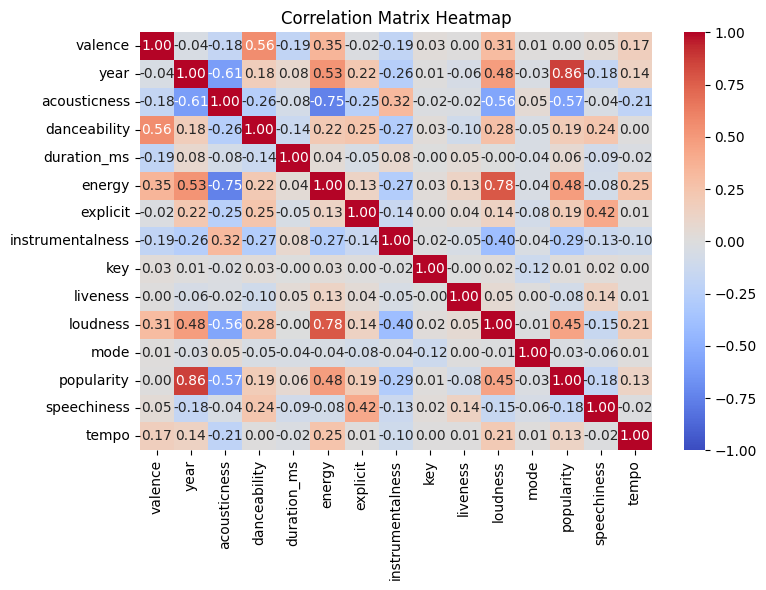

In [ ]:
corr_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

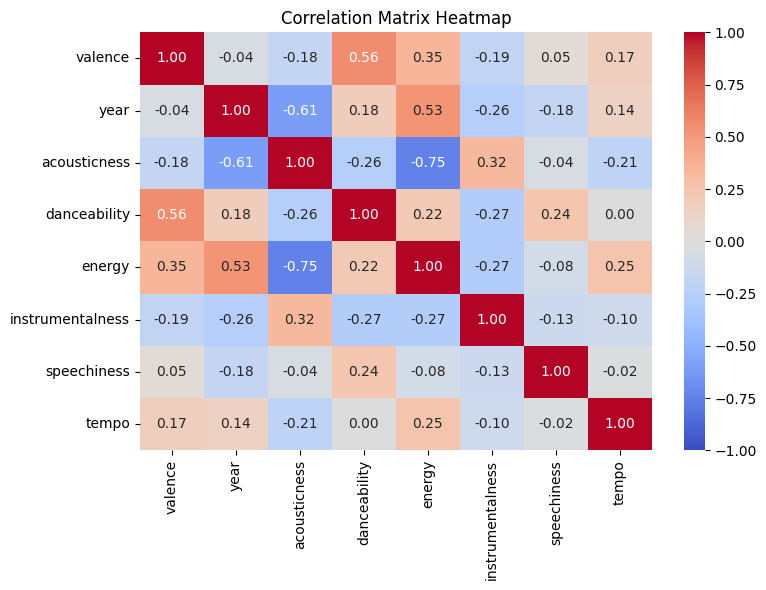

In [ ]:
#Dropping columns
X = X.drop(columns=['popularity', 'loudness', 'mode', 'explicit', 'key', 'duration_ms', 'liveness'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

corr_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

PC1: 34.86% variance explained
PC2: 53.72% variance explained
PC3: 66.42% variance explained
PC4: 77.99% variance explained
PC5: 87.31% variance explained
PC6: 94.16% variance explained
PC7: 97.53% variance explained
PC8: 100.00% variance explained


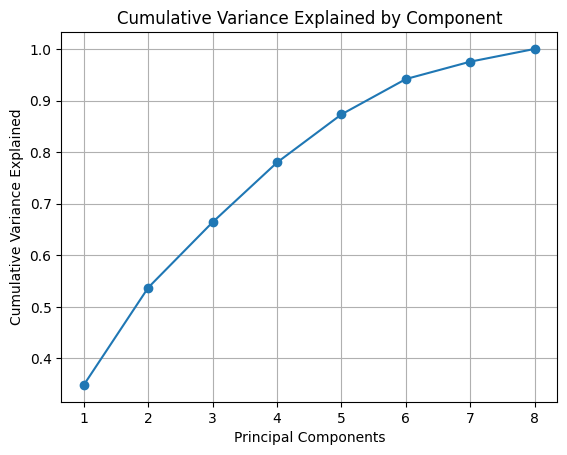

In [ ]:
pca_check = PCA(n_components=X.shape[1])
X_pca_check = pca_check.fit_transform(X_scaled)
var = pca_check.explained_variance_ratio_

cumulative_var = var.cumsum()
for PC, var in enumerate(cumulative_var):
  print(f"PC{PC+1}: {var*100:.2f}% variance explained")

plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Component')
plt.grid(True)
plt.show()

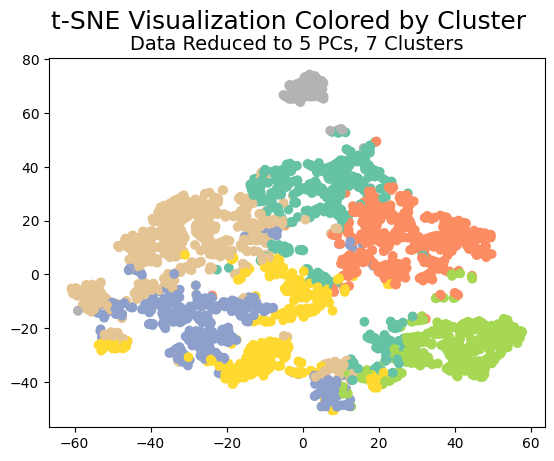

In [ ]:
from sklearn.manifold import TSNE # for visualizing clusters
from sklearn.utils import resample
pca = PCA(n_components=5)           # 5 PCs captured 80% of the variance
X_pca = pca.fit_transform(X_scaled)


X_sample = resample(X_scaled, n_samples=3000,random_state=5533) # random sample for runtime efficiency
X_pca_sample = pca.transform(X_sample) # pca on sample for visualizing
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=7, random_state=5533))])
cluster_pipeline.fit(X_sample)
sample_labels = cluster_pipeline.predict(X_sample)

X_tsne = TSNE(n_components=2, perplexity=30, random_state=5533).fit_transform(X_pca_sample)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sample_labels, cmap='Set2')
plt.suptitle("t-SNE Visualization Colored by Cluster", fontsize=18)
plt.title("Data Reduced to 5 PCs, 7 Clusters", fontsize=14)
plt.show()



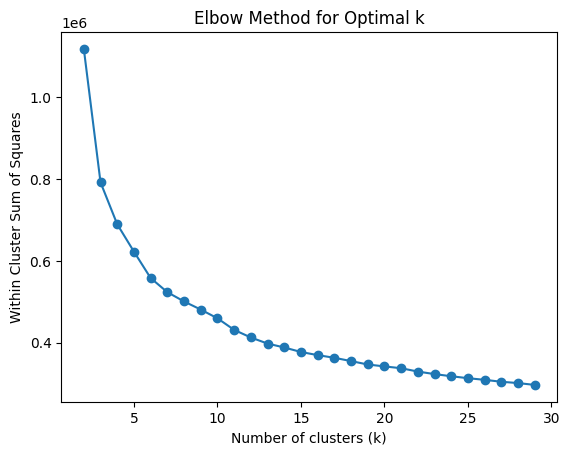

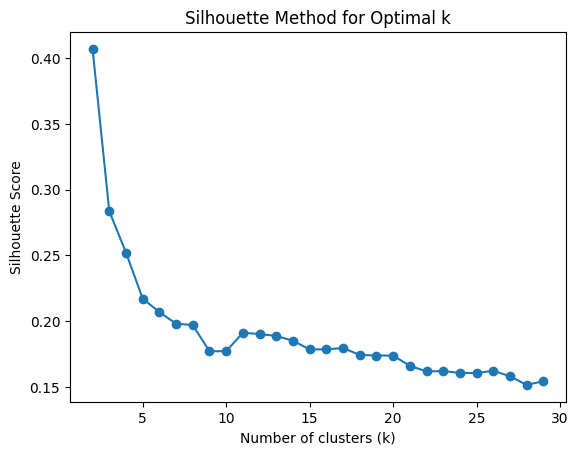

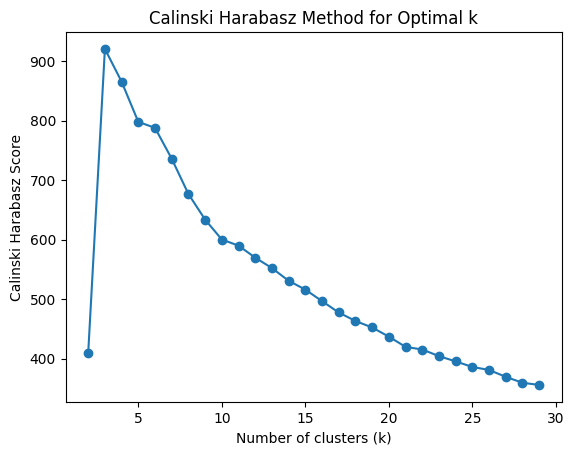

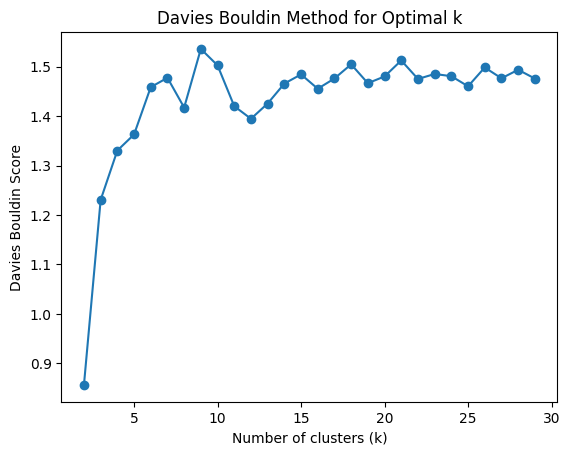

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

WCSS = [] # within cluster sum of squares
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

k = range(2,30)

for num in k:
  kmeans = KMeans(n_clusters=num, random_state=5533)
  kmeans.fit(X_scaled)
  labels = kmeans.predict(X_sample)

  WCSS.append(kmeans.inertia_)
  silhouette_scores.append(silhouette_score(X_sample, labels))
  calinski_harabasz_scores.append(calinski_harabasz_score(X_sample, labels))
  davies_bouldin_scores.append(davies_bouldin_score(X_sample, labels))

plt.plot(k, WCSS, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()

plt.plot(k, silhouette_scores, marker='o') # higher peak favorable
plt.title('Silhouette Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

plt.plot(k, calinski_harabasz_scores, marker='o') # higher peak favorable
plt.title('Calinski Harabasz Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski Harabasz Score')
plt.show()

plt.plot(k, davies_bouldin_scores, marker='o') # lowest dip favorable
plt.title('Davies Bouldin Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies Bouldin Score')
plt.show()

In [ ]:
spotify_copy = spotify.copy()

#adding pca features to dataframe (5 PCs)
for i in range(X_pca.shape[1]):
    spotify_copy[f'PC{i+1}'] = X_pca[:, i]

#clustering on PCA components
kmeans = KMeans(n_clusters=7, random_state=5533)
labels = kmeans.fit_predict(X_pca)
spotify_copy['cluster'] = labels #adds label data to spotify_copy

In [ ]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df['cluster'] = labels
cluster_feature_avgs = X_scaled_df.groupby('cluster')[X.columns].mean().round(2).reset_index()

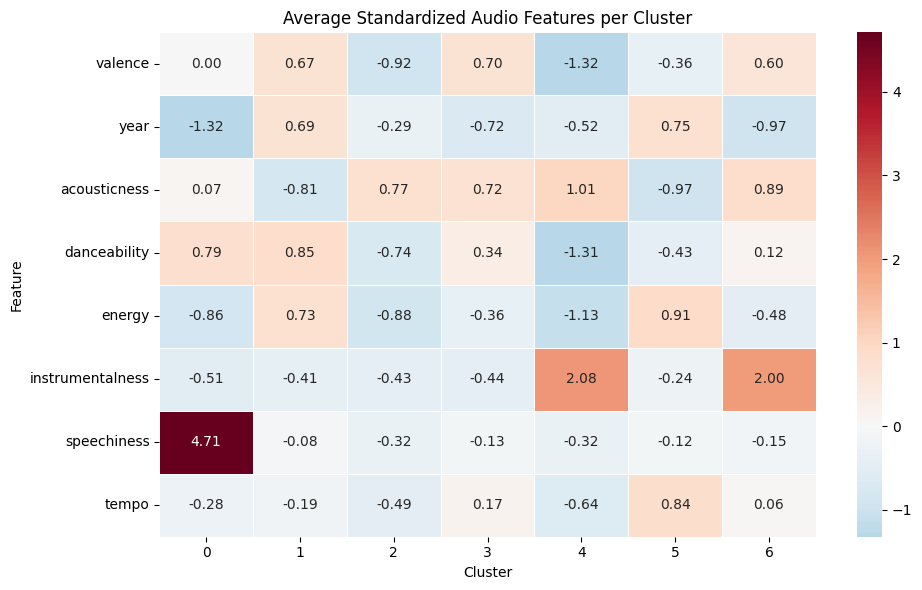

In [ ]:
heat_df = cluster_feature_avgs.set_index("cluster").T

plt.figure(figsize=(10, 6))
sns.heatmap(
    heat_df,
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
    annot=True,
    fmt=".2f"
)

plt.title("Average Standardized Audio Features per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
#helper to get main artist for songs with multiple/featured artists
def get_first_artist(artists_entry):
    if isinstance(artists_entry, list):
        return artists_entry[0]
    elif isinstance(artists_entry, str) and artists_entry.startswith("["):
        try:
            parsed = ast.literal_eval(artists_entry)
            if isinstance(parsed, list) and parsed:
                return parsed[0]
        except:
            pass
    return artists_entry

#helper function to match chosen artist to data
def artist_match(artists_entry, selected_artist):
    selected = selected_artist.lower().strip()
    if isinstance(artists_entry, list):
        return selected in [a.lower().strip() for a in artists_entry]
    elif isinstance(artists_entry, str) and artists_entry.startswith("["):
        try:
            parsed = ast.literal_eval(artists_entry)
            if isinstance(parsed, list):
                return selected in [a.lower().strip() for a in parsed]
        except:
            return False
    return artists_entry.lower().strip() == selected


In [ ]:
# add an avg popularity to the artists
import ast

spotify['artists'] = spotify['artists'].apply(ast.literal_eval)
spotify_exploded = spotify.explode('artists')

artist_avg = spotify_exploded.groupby('artists')['popularity'].mean().reset_index()
artist_avg.columns = ['artist', 'avg_popularity']
artist_avg = artist_avg.sort_values('avg_popularity', ascending=False)

spotify_copy['main_artist'] = spotify_copy['artists'].apply(get_first_artist)
spotify_copy = spotify_copy.merge(artist_avg, left_on='main_artist', right_on='artist', how='left')
spotify_copy = spotify_copy.drop(columns=['artist'])



In [ ]:
#Recommender

while True:
    print("\nMusic Recommender — Choose a Decade")
    try:
        decade = int(input("Enter a decade (ex. 1980): ").strip())
        filtered_df = spotify_copy[
            (spotify_copy['year'] >= decade) & (spotify_copy['year'] < decade + 10)
        ]
    except:
        print("Invalid input. Please enter a valid decade (ex. 1980).")
        continue

    if filtered_df.empty:
        print("No songs found in that decade.")
        continue

    unique_artists = filtered_df.sort_values('avg_popularity', ascending=False)['main_artist'].unique()

    while True:
        print("\nWould you like to:")
        print("1. See all artists")
        print("2. Search by artist name")
        artist_mode = input("Enter 1 or 2: ").strip()

        if artist_mode == '1':
            matches = unique_artists
            print(f"\nFound {len(matches)} artists from the {decade}s.")

            page_size = 20
            page = 0
            while True:
                start = page * page_size
                end = start + page_size
                current_page = matches[start:end]

                if current_page.size == 0:
                    print("No more artists to display.")
                    break

                print(f"\nArtists {start+1} to {min(end, len(matches))}:")
                for i, artist in enumerate(current_page, start=start+1):
                    print(f"{i}. {artist}")

                try:
                    user_input = input("\nEnter the number of the artist you'd like to choose, 'n' to go to next page, or p to go to the previous page: ").strip()
                    if user_input == 'n':
                        page += 1
                    elif user_input == 'p':
                        if page > 0:
                            page -= 1
                    elif user_input.isdigit():
                        artist_choice = int(user_input)
                        selected_artist = matches[artist_choice - 1]
                        break

                except (ValueError, IndexError):
                    print("Invalid artist selection. Returning to main menu.")
                    break

            if selected_artist:
              break

        elif artist_mode == '2':
            while True:
                artist_query = input("\nType part of the artist's name (or type 'clear' to start over): ").strip().lower()

                if artist_query == 'clear':
                    print("Restarting artist search.")
                    continue

                matches = [a for a in unique_artists if artist_query in a.lower()]
                if matches:
                    print("\nMatching artists:")
                    for i, artist in enumerate(matches[:10]):
                        print(f"{i+1}. {artist}")
                    try:
                        artist_choice = int(input("\nEnter the number of the artist you'd like to choose: ").strip())
                        selected_artist = matches[artist_choice - 1]
                    except (ValueError, IndexError):
                        print("Invalid artist selection. Returning to main menu.")
                        continue
                    break
                else:
                    print("No matches found. Try again or type 'clear' to reset.")
            break

        else:
            print("Invalid option. Please enter 1 or 2.")

    songs_by_artist = filtered_df[filtered_df['main_artist'] == selected_artist]['name'].unique()
    print(f"\nSongs by {selected_artist}:")
    for i, song in enumerate(songs_by_artist):
        print(f"{i+1}. {song}")

    try:
        song_choice = int(input("\nEnter the number of the song you'd like to choose: ").strip())
        selected_song = songs_by_artist[song_choice - 1]
    except (ValueError, IndexError):
        print("Invalid song selection. Returning to main menu.")
        continue

    possible_matches = spotify_copy[spotify_copy['name'].str.lower().str.strip() == selected_song.lower().strip()]
    possible_matches = possible_matches[possible_matches['artists'].apply(lambda x: artist_match(x, selected_artist))]

    if possible_matches.empty:
        print("Song not found in full dataset. Showing all songs with that title:")
        debug_matches = spotify_copy[spotify_copy['name'].str.lower().str.strip() == selected_song.lower().strip()]
        print(debug_matches[['name', 'artists']].head(5).to_string(index=False))
        continue

    song_row = possible_matches.iloc[0:1]  # take the first match
    pca_cols = [col for col in spotify_copy.columns if col.startswith('PC')]
    selected_features = song_row[pca_cols].values[0]

    cluster_songs = spotify_copy[spotify_copy['cluster'] == song_row['cluster'].values[0]].copy()
    cluster_songs['distance'] = cluster_songs[pca_cols].apply(
        lambda row: np.linalg.norm(row.values - selected_features), axis=1
    )

    recommendations = cluster_songs[
        (cluster_songs['name'].str.lower().str.strip() != selected_song.lower().strip()) |
        (~cluster_songs['artists'].apply(lambda x: artist_match(x, selected_artist)))
    ].sort_values('distance').head(5)

    print("\nTop 5 Recommended Songs:")
    print(recommendations[['artists', 'name', 'distance']].to_string(index=False))

    again = input("\nWould you like to try another song? (y/n): ").strip().lower()
    if again != 'y':
        print("Goodbye!")
        break



Music Recommender — Choose a Decade
No songs found in that decade.

Music Recommender — Choose a Decade

Would you like to:
1. See all artists
2. Search by artist name

Found 600 artists from the 2020s.

Artists 1 to 20:
1. Ritt Momney
2. Lele Pons
3. Jerry Di
4. Jawsh 685
5. salem ilese
6. Master KG
7. Joel Corry
8. Aya Nakamura
9. HVME
10. THE SCOTTS
11. Octavian
12. Topic
13. MEDUZA
14. twocolors
15. Nea
16. CJ
17. Alexander 23
18. Fousheé
19. Tones And I
20. Zoe Wees

Artists 1 to 20:
1. Ritt Momney
2. Lele Pons
3. Jerry Di
4. Jawsh 685
5. salem ilese
6. Master KG
7. Joel Corry
8. Aya Nakamura
9. HVME
10. THE SCOTTS
11. Octavian
12. Topic
13. MEDUZA
14. twocolors
15. Nea
16. CJ
17. Alexander 23
18. Fousheé
19. Tones And I
20. Zoe Wees

Artists 1 to 20:
1. Ritt Momney
2. Lele Pons
3. Jerry Di
4. Jawsh 685
5. salem ilese
6. Master KG
7. Joel Corry
8. Aya Nakamura
9. HVME
10. THE SCOTTS
11. Octavian
12. Topic
13. MEDUZA
14. twocolors
15. Nea
16. CJ
17. Alexander 23
18. Fousheé
19. To